In [1]:
import pandas as pd

df_history = pd.read_parquet("/kaggle/input/copy-of-ml-1-shad-fall-2022/history_train.pq")
df_history.head(5)

,category_id,microcategory_id,item_id,event_type,source_event_type,request_id,location_id,event_age_seconds
0,31,189,979366,0,0,136128,5215,2651288
1,31,6321,979366,2,8,136128,161,2651246
2,31,6321,979366,4,8,136128,5215,2651229
3,31,189,11420517,0,0,136128,5215,2651206
4,31,189,15674214,0,0,136128,5215,2651198


In [2]:
import torch

class HistoryDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.history_df = df
        
    def __getitem__(self, index):
        return self.history_df['item_id'].iloc[index], \
               self.history_df['source_event_type'].iloc[index], \
               self.history_df['request_id'].iloc[index]
    
    def __len__(self):
        return self.history_df.shape[0]

dataset = HistoryDataset(df_history)

In [3]:
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)

In [4]:
for batch in loader:
    break
batch

[tensor([  979366,   979366,   979366, 11420517, 15674214,  7843485,  7843485,
           979366,   979366,   979366,   979366, 28916079, 20655306,   979366,
         27061492, 15190380]),
 tensor([0, 8, 8, 0, 0, 0, 0, 1, 8, 1, 1, 2, 2, 8, 7, 2]),
 tensor([136128, 136128, 136128, 136128, 136128, 136128, 136128, 136128, 136128,
         136128, 136128, 136128, 136128, 136128, 136128, 136128])]

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class DSSM(nn.Module):
    def __init__(self, n_items, n_requests, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding_items = nn.Embedding(n_items, embedding_dim)
        self.embedding_requests = nn.Embedding(n_requests, embedding_dim)
        
        self.net1 = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        self.net2 = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        self.last = nn.Linear(2 * hidden_dim, 1)
        
    def forward(self, batch):
        emb_1 = self.embedding_items(batch[0])
        emb_2 = self.embedding_requests(batch[2])
        hid_1 = self.net1(emb_1)
        hid_2 = self.net2(emb_2)
        hid = torch.cat((hid_1, hid_2), 1)
        return self.last(hid)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
model = torch.load('/kaggle/input/dssm-competition-training/model.pt').to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [8]:
import os

os.environ['CUDA_LAUNCH_BLOCKING']="1"

In [9]:
1066703 // 20

53335

In [10]:
from tqdm.auto import tqdm

losses = []
pbar = tqdm(enumerate(loader))

iterations = 1066703 // 17
save_model_iter = 2000


for i, batch in pbar:
    if i >= iterations:
        break
    if i % save_model_iter == 0:
        print(i)
        torch.save(model, 'model.pt')
    optimizer.zero_grad()
    for i in range(3):
        batch[i] = batch[i].to(device)
    output = model(batch)
    loss = criterion(output.reshape(-1), batch[1].to(device) + 0.0)
    loss.backward()
    losses.append(loss.item())
    pbar.set_description(f"loss train: {loss.item()}")
    optimizer.step()

0it [00:00, ?it/s]

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000
58000
60000
62000


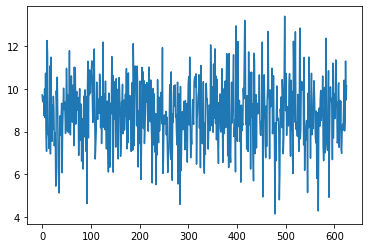

In [11]:
import matplotlib.pyplot as plt
import numpy as np


def mean_window(arr, window_size):
    answers = []
    for i in range(len(arr) // window_size - 1):
        start_ind = i * window_size
        end_ind = start_ind + window_size
        answers.append(sum(arr[start_ind:end_ind]) / window_size)
    return answers

mean_losses = mean_window(losses, 100)
plt.plot(np.arange(len(mean_losses)), mean_losses)